In [2]:
from bioservices.kegg import KEGG
import numpy as np
import matplotlib.pyplot as plt
import readline
import random
# FDR
from rpy2.robjects.packages import importr
from rpy2.robjects.vectors import FloatVector
# Hypergeom
from scipy.stats import hypergeom
# LogNorm color scheme
import matplotlib.colors as colors
# Combinations
from itertools import combinations

In [3]:
def read_annotations(annotation_file):
    annotation_fh = open(annotation_file, 'r')
    annotations = annotation_fh.readlines()
    annotations = list(map(str.rstrip, annotations))
    annotation_fh.close()
    return annotations

def filter_zscores(ko_index, modzscore_file, annotations, zscore_threshold):
    '''
    Due to RAM restrictions, must generate input list on the fly
    '''
    metabolite_hits = []
    modz_fh = open(modzscore_file, 'r')
    modz_lines = modz_fh.readlines()
    modz_fh.close()
    for index in range(0, len(modz_lines)):
        line = modz_lines[index]
        zscores = line.rstrip().split()
        exp_zscore = float(zscores[ko_index]) # The zscore of that knockout
        if abs(exp_zscore) >= zscore_threshold:
            kegg_id = annotations[index]
            if kegg_id.startswith('C'): # Verifying KEGG ids
                metabolite_hits.append(kegg_id)
    metabolite_hits = set(metabolite_hits)
    return metabolite_hits

def build_metabo_input(ko_index, 
                       pos_annotation_file, pos_modzscore_file, 
                       neg_annotation_file, neg_modzscore_file, 
                       zscore_threshold):
    pos_annotations = read_annotations(pos_annotation_file)
    neg_annotations = read_annotations(neg_annotation_file)

    pos_hits = filter_zscores(ko_index, pos_modzscore_file, pos_annotations, zscore_threshold)
    neg_hits = filter_zscores(ko_index, neg_modzscore_file, neg_annotations, zscore_threshold)
    
    metabolite_hits = pos_hits | neg_hits
    return metabolite_hits

In [4]:
# Get ALL the compounds within a species's pathway db
def get_all_compounds(species):
    # Initiate KEGG instance
    kegg_inst = KEGG()
    kegg_inst.organism = species
    # Get all compounds
    all_compounds = set()
    species_pathways = kegg_inst.pathwayIds
    for pathway in species_pathways:
        parsed_output = kegg_inst.parse(kegg_inst.get(pathway)) # parsed_ouput has lots of information about the pathway
        try:
            compounds = set(parsed_output['COMPOUND'].keys())
            all_compounds = all_compounds | compounds
        except KeyError: # Some pathways do not have defined compounds
            pass
    return all_compounds

In [5]:
def loadTsv(filename):
    fh = open(filename, 'r')
    outset = set()
    for line in fh:
        if line.startswith('C'):
            outset = outset | set([line.rstrip()])
    fh.close()
    return outset

In [6]:
# ORA (only for E.coli)
def ora(in_metabolites, pathway_id, bg_metabolites, pathway_2_compounds, least_num_metabolites=1):
    '''
    Specifying a KEGG instance is way faster than creating one on the fly
    Need to specify organism for that instance though
    '''
    # Get compounds
    try:
        compounds = pathway_2_compounds[pathway_id]
    except KeyError:
        return 'No compounds (DB)'
    # Background filtering
    test_pathway_compounds = compounds & bg_metabolites
    if len(test_pathway_compounds) == 0:
        return 'No compounds (BG)'
    # Hypergeometric test
    test_in_metabolites = in_metabolites & test_pathway_compounds
    if len(test_in_metabolites) < least_num_metabolites:
        return 'Low metabolites'
    hyperg_test = hypergeom(len(bg_metabolites), len(test_pathway_compounds), len(in_metabolites & bg_metabolites))
    #print(len(in_metabolites), len(in_metabolites & bg_metabolites))
    #print(in_metabolites - bg_metabolites)
    ora_raw_pval = 1 - hyperg_test.cdf(len(test_in_metabolites)) + hyperg_test.pmf(len(test_in_metabolites))
    #print(hyperg_test.cdf(len(test_in_metabolites)))
    #print(hyperg_test.pmf(len(test_in_metabolites)))
    return ora_raw_pval, pathway_id, len(test_pathway_compounds)

In [7]:
def misidentify(in_metabolites, times, pool_metabolites, return_changes = False):
    '''
    in_metabolites: set of in metabolites
    times: number of misidentification
    pool_metabolites: set pool of metabolites which the new identification can be
    '''
    in_metabolites = list(in_metabolites)
    pool_metabolites = list(pool_metabolites)
    # Adjusting times so times <= length of in metabolties
    if times > len(in_metabolites):
        times = len(in_metabolites)
    elif times > (len(pool_metabolites) - len(in_metabolites)):
        times = (len(pool_metabolites) - len(in_metabolites))
    if times == 0:
        return in_metabolites
    # Generating new identifications
    new_ident = []
    for i in range(0, times):
        random.shuffle(pool_metabolites)
        new_metabolite = pool_metabolites[0]
        # If new metab is already in the input list, discard and generate new ones
        while new_metabolite in in_metabolites:
            random.shuffle(pool_metabolites)
            new_metabolite = pool_metabolites[0]
        new_ident.append(new_metabolite)
    # Swapping existed metabolites for new metabolites
    old_ident = []
    random.shuffle(in_metabolites)
    for i in range(0, times):
        old_ident.append(in_metabolites.pop())
    in_metabolites += new_ident
    out_metabolites = set(in_metabolites)
    # Added an option to return identity changes
    if return_changes:
        return out_metabolites, old_ident, new_ident
    else:
        return out_metabolites

In [8]:
# Run ORAs for all pathways in a single knockout
def oras_ko(ko_number, testing_pathways, background_metabolites, pathway_2_compounds,  
            pos_annotation_file, pos_modzscore_file, 
            neg_annotation_file, neg_modzscore_file, 
            zscore_threshold, 
            multiple_testing_correction, minus_log_trans, max_mutation, mutation_pool):
    
    ko_metabolites = build_metabo_input(ko_number, 
                       pos_annotation_file, pos_modzscore_file, 
                       neg_annotation_file, neg_modzscore_file, 
                       zscore_threshold)
    # Random Mutation
    if max_mutation:
        tmp_metabolites = ko_metabolites # Copy ko_metabolites
        (background_metabolites, old_met, new_met) = misidentify(background_metabolites, 
                                                                 max_mutation, mutation_pool, True)
        met_translate = dict(zip(old_met, new_met)) # Make a dictionary for translation
        ko_metabolites = set() # Empty ko_metabolites
        for met in tmp_metabolites: # For each member in tmp, translate them and add them back to ko_metabolites
            ko_metabolites.add(met_translate.get(met, met))
    # Generating raw p values
    pval = []
    pathwayid = []
    pathwaysize = []
    for pathway in testing_pathways:
        ora_res = ora(ko_metabolites, pathway, background_metabolites, pathway_2_compounds)
        if len(ora_res) == 3: # if both ora_raw_pval and pathway_id are returned
            pval.append(ora_res[0])
            pathwayid.append(ora_res[1])
            pathwaysize.append(ora_res[2])
    # Multiple testing correction
    if multiple_testing_correction:
        pval = list(importr('stats').p_adjust(FloatVector(pval), method = 'BH'))
    # -log transformation
    if minus_log_trans:
        pval = list(map(np.log10, pval))
        pval = list(map(np.negative, pval))
    return pval, pathwayid, pathwaysize

In [22]:
# Generating null models
def make_null_model(original_model, metabolite_pool, overlap=False):
    '''
    original_model -- the dictionary with pathways as keys and metabolites as values
    metabolite_pool -- the collection of metabolites which the null model can include
    overlap -- True: overlap between pathways will not be randomised; False: overlap will be randomised
    '''
    if overlap:
        # If keeping the metabolite overlap, we only shuffle the labels of the metabolites
        
        # Getting the original metabolites
        original_metabolites = set()
        for value in original_model.values():
            original_metabolites = original_metabolites | value
        original_metabolites = list(original_metabolites)
        
        random.shuffle(metabolite_pool)
        metabolite_translate = dict(zip(original_metabolites, metabolite_pool[:len(original_metabolites)]))
    new_model = dict()
    for pathway in original_model:
        pathwaysize = len(original_model[pathway])
        if overlap:
            new_model[pathway] = set()
            for metabolite in original_model[pathway]:
                new_model[pathway].add(metabolite_translate[metabolite])
        else:
            for i in range(0, pathwaysize):
                random.shuffle(metabolite_pool)
                new_model[pathway] = set(metabolite_pool[:pathwaysize])
    return new_model

In [10]:
# Save null models and load null models
def save_null_model(model, filename):
    '''
    model in the type of a dictionary
    keys = pathway name
    values = metabolites (set)
    '''
    with open(filename, 'w') as fh:
        for pathway in model:
            metabolites = list(model[pathway])
            fh.write(pathway+'\t')
            fh.write(','.join(metabolites))
            fh.write('\n')
            
def load_null_model(filename):
    model = dict()
    with open(filename, 'r') as fh:
        for line in fh.readlines():
            fields = line.rstrip().split('\t')
            pathway = fields[0]
            metabolites = set(fields[1].split(','))
            model[pathway] = metabolites
    return model

## Null models & Jaccard coefficients etc

In [24]:
for i in range(0, 100):
    filename = ('/home/zxu/Documents/mscbioinfo/Data Project/scripts/Jupyter/null_models/random/' + 
                'model' + str(i) + '.tsv')
    null_model = make_null_model(pathway_2_compounds, list(test_compounds), True)
    #save_null_model(null_model, filename)
    print(null_model['path:eco00010'])

{'C05588', 'C06582', 'C14083', 'C14717', 'C00007', 'C14113', 'C00517', 'C01273', 'C04332', 'C16254', 'C05265', 'C02939', 'C06251', 'C11418', 'C00364', 'C03599', 'C09815', 'C05396', 'C18902', 'C14824', 'C11521', 'C14087', 'C01751', 'C00170', 'C20772', 'C05313', 'C00416', 'C05856', 'C16848', 'C00504', 'C15812'}
{'C12621', 'C18102', 'C15700', 'C04593', 'C17559', 'C00021', 'C07096', 'C16241', 'C11453', 'C08491', 'C00887', 'C03933', 'C04574', 'C17660', 'C05994', 'C14814', 'C18240', 'C16239', 'C04822', 'C17664', 'C06705', 'C17948', 'C01272', 'C03586', 'C19567', 'C16193', 'C20518', 'C01967', 'C12144', 'C14156', 'C03345'}
{'C00196', 'C04823', 'C01606', 'C19609', 'C01368', 'C01180', 'C03539', 'C03561', 'C21231', 'C00440', 'C03035', 'C19852', 'C05964', 'C05281', 'C01717', 'C06620', 'C19725', 'C02430', 'C01230', 'C16281', 'C00524', 'C00261', 'C20251', 'C01946', 'C02225', 'C11408', 'C20666', 'C05984', 'C01269', 'C12481', 'C00305'}
{'C00196', 'C05805', 'C00155', 'C00002', 'C04592', 'C00349', 'C0166

In [60]:
print(len(null_model['path:eco00010'] & null_model['path:eco00030']))
print(len(pathway_2_compounds['path:eco00010'] & pathway_2_compounds['path:eco00030']))

10
10


In [80]:
null_jaccard = []
kegg_jaccard = []
for i in combinations(pathway_2_compounds, 2):
    null_jaccard.append(len(null_model[i[0]] & null_model[i[1]]) / len(null_model[i[0]] | null_model[i[1]]))
    kegg_jaccard.append(len(pathway_2_compounds[i[0]] & pathway_2_compounds[i[1]]) / len(pathway_2_compounds[i[0]] | pathway_2_compounds[i[1]]))


In [79]:
np.var(null_jaccard)

0.00035449817750320839

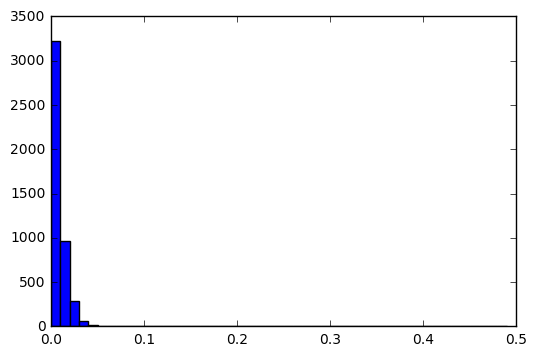

In [81]:
bins = np.arange(0, 0.5, 0.01)
hist, bin_edges = np.histogram(null_jaccard, bins=bins)
plt.clf()
plt.bar(bins[:-1],hist,width=np.diff(bins))
plt.show()

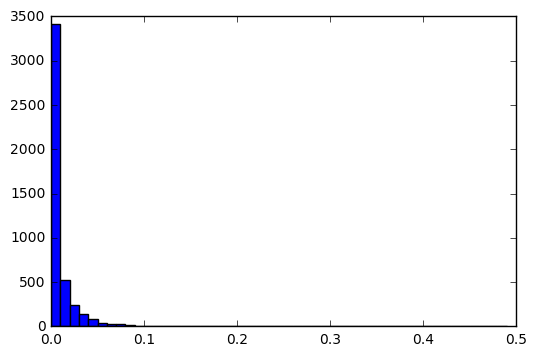

In [82]:
bins = np.arange(0, 0.5, 0.01)
hist, bin_edges = np.histogram(kegg_jaccard, bins=bins)
plt.clf()
plt.bar(bins[:-1],hist,width=np.diff(bins))
plt.show()

#### Generating results using null models

In [24]:
sig_count = 0
for ko_number in range(0, len(all_knockouts)):
    nullmod_pval, nullmod_pathway_id, nullmod_sizes = oras_ko(ko_number, ecoli_pathways, zamboni_bg, null_model, 
                        pos_annot, pos_mod, neg_annot, neg_mod, 2, False, False, 0, [])
    for i in nullmod_pval:
        if i < 0.05:
            sig_count += 1
print(sig_count)

6215


# Analysis & Stuffs
3717 Knockouts in total (0 to 3716)

In [58]:
'C00186' in zamboni_bg

False

In [57]:
build_metabo_input(2281, pos_annot, pos_mod, neg_annot, neg_mod, 5)

{'C00042',
 'C00148',
 'C00222',
 'C00244',
 'C00350',
 'C00417',
 'C00438',
 'C00666',
 'C01013',
 'C01216',
 'C01419',
 'C02637',
 'C04236',
 'C05512',
 'C11514'}

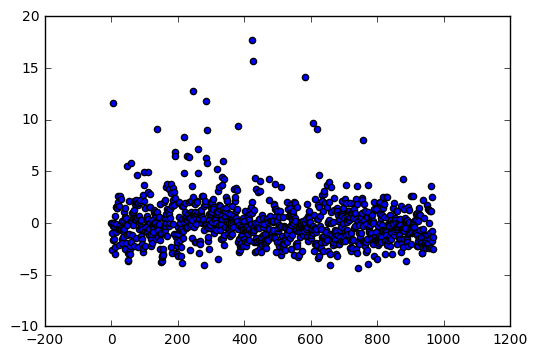

In [54]:
fh = open('/home/zxu/Documents/mscbioinfo/Data Project/Zamboni/modzscore_neg_annotated.tsv', 'r')
lines = fh.readlines()
ko_scores = []
for line in lines:
    #print(len(line.rstrip().split('\t')))
    score = line.rstrip().split('\t')[2281]
    ko_scores.append(score)
plt.scatter(np.arange(len(ko_scores)), ko_scores)
plt.show()

In [44]:
all_knockouts.index('ybjO')

2281

In [17]:
build_metabo_input(1541, pos_annot, pos_mod, neg_annot, neg_mod, 10)

set()

In [8]:
for ko_number in range(0, len(all_knockouts)):
    fh = open('./Backgrounds/KO' + str(ko_number) + '.tsv', 'r')
    nobg_pval = []
    nobg_pathways = []
    nobg_size = []
    zamboni_pval = []
    lines = fh.readlines()
    for line in lines:
        fields = line.rstrip().split('\t')
        nobg_pval.append(float(fields[1]))
        nobg_pathways.append(fields[0])
        nobg_size.append(fields[2])
        zamboni_pval.append(float(fields[3]))
    fh.close()
    if len(nobg_pval) == 0:
        continue
    elif max(nobg_pval) < 1.30 and max(zamboni_pval) < 1.30:
        continue
    print('<OPTION VALUE="{}">{}</option>'.format(ko_number, all_knockouts[ko_number]), end='')

NameError: name 'all_knockouts' is not defined

## Preparation for analysis

In [11]:
# Stating the annotation files & modzscore files
pos_annot = '/home/zxu/Documents/mscbioinfo/Data Project/Zamboni/annotation_pos.txt'
pos_mod = '/home/zxu/Documents/mscbioinfo/Data Project/Zamboni/modzscore_pos_annotated.tsv'
neg_annot = '/home/zxu/Documents/mscbioinfo/Data Project/Zamboni/annotation_neg.txt'
neg_mod = '/home/zxu/Documents/mscbioinfo/Data Project/Zamboni/modzscore_neg_annotated.tsv'
# Initialise KEGG instance
k = KEGG()
k.organism = "eco"
# Initialise both backgrounds
test_compounds = get_all_compounds('eco')
zamboni_bg = loadTsv('/home/zxu/Documents/mscbioinfo/Data Project/Zamboni/annotation_all.txt')
zamboni_bg = zamboni_bg & test_compounds
# build {pathway: compounds} dictionary for E.coli
ecoli_pathways = k.pathwayIds
pathway_2_compounds = dict()
for pathway in ecoli_pathways:
    parsed_output = k.parse(k.get(pathway)) # parsed_ouput has lots of information about the pathway
    try:
        compounds = set(parsed_output['COMPOUND'].keys())
        pathway_2_compounds[pathway] = compounds
    except KeyError: # Some pathways do not have defined compounds
        #name = parsed_output['NAME']
        #print(pathway, name)
        pass

In [12]:
# Translate KO number to gene name
sample_id_all = '/home/zxu/Documents/mscbioinfo/Data Project/Zamboni/sample_id_modzscore.tsv'
all_knockouts = []# End product
fh_sample_id_all = open(sample_id_all, 'r')
for knockout in fh_sample_id_all:
    all_knockouts.append(knockout.rstrip())
fh_sample_id_all.close()
#print(all_knockouts)

## Analysis 0: Translate compound names (Raboniwitz)

#### Manual KEGG translation

In [30]:
fh = open('rabinowitz.txt', 'r')
rabinowitz_lines = fh.readlines()
for line in rabinowitz_lines[80:85]:
    compound = line.rstrip()
    if compound.endswith(')'):
        compound = compound.split(' (')[0]
    print(compound)
    print(k.find('compound', compound))
    print('=' * 20)
fh.close()

NADP  +
cpd:C00005	NADPH; TPNH; Reduced nicotinamide adenine dinucleotide phosphate
cpd:C00006	NADP+; NADP; Nicotinamide adenine dinucleotide phosphate; beta-Nicotinamide adenine dinucleotide phosphate; TPN; Triphosphopyridine nucleotide; beta-NADP+
cpd:C03024	[Reduced NADPH---hemoprotein reductase]; Reduced flavoprotein
cpd:C03161	[Oxidized NADPH---hemoprotein reductase]; Oxidized flavoprotein
cpd:C04125	[Isocitrate dehydrogenase (NADP+)]
cpd:C04564	[Isocitrate dehydrogenase (NADP+)] phosphate
cpd:C04632	[Hydroxymethylglutaryl-CoA reductase (NADPH)]
cpd:C04749	[[Hydroxymethylglutaryl-CoA reductase (NADPH)]kinase]
cpd:C04768	[Hydroxymethylglutaryl-CoA reductase (NADPH)] phosphate
cpd:C04816	Dephospho-[[hydroxymethylglutaryl-CoA reductase (NADPH)]kinase]
cpd:C04899	(6S)-6beta-Hydroxy-1,4,5,6-tetrahydronicotinamide-adenine dinucleotide phosphate; (S)-NADPH-hydrate; (S)-NADPHX; (6S)-6beta-Hydroxy-1,4,5,6-tetrahydronicotinamide-adenine dinucleotide 2'-phosphate
cpd:C20483	(6R)-6beta-Hydrox

In [10]:
met_conc = {}
with open('/home/zxu/Documents/mscbioinfo/Bioinfo Project/rabinowitz_conc.csv', 'r') as fh:
    lines = fh.readlines()
    for line in lines:
        fields = line.rstrip().split('\t')
        # Converting the concentration to actual numbers
        conc = fields[0]
        value = conc.split(' ')[0]
        power = conc.split('− ')[1]
        number = float(value) * 10 ** (-int(power))
        metabolite = fields[1]
        met_conc[metabolite] = number
# Might use if we want to cut off based on concentrations
rab_met = sorted(met_conc, key=met_conc.get, reverse=True)

#### Generating the small background results

In [11]:
for ko_number in range(0, len(all_knockouts)):
    rabbg_pval, rabbg_pathway_id, rabbg_sizes = oras_ko(ko_number, ecoli_pathways, zamboni_bg & set(rab_met), pathway_2_compounds, 
                        pos_annot, pos_mod, neg_annot, neg_mod, 2, True, False, 0, [])
    with open('./rabinowitz/full/KO' + str(ko_number) + '.tsv', 'w') as fh:
        for i in range(0, len(rabbg_pval)):
            fh.write(rabbg_pathway_id[i][5:] + '\t' + str(rabbg_pval[i]) + '\n')

#### Comparing the small background results with the original results
* p-value distribution
* number of significant hits

In [13]:
zamboni_pval = []
rabinowitz_pval = []
for ko_number in range(0, len(all_knockouts)):
    ora_results = {}
    
    rabinowitz_results = './rabinowitz/full/KO' + str(ko_number) + '.tsv'
    zamboni_results = './allresult/KO' + str(ko_number) + '.tsv'
    with open(rabinowitz_results, 'r') as rabinowitz_fh:
        for line in rabinowitz_fh.readlines():
            fields = line.rstrip().split('\t')
            pathname = fields[0]
            pathpval = float(fields[1])
            ora_results[pathname] = pathpval
    with open(zamboni_results, 'r') as zamboni_fh:
        for line in zamboni_fh.readlines():
            fields = line.rstrip().split('\t')
            pathname = fields[0]
            pathpval = float(fields[1])
            try:
                rabinowitz_pval.append(ora_results[pathname])
                zamboni_pval.append(pathpval)
            except KeyError:
                pass
print(len(zamboni_pval), len(rabinowitz_pval))

86629 86629


In [16]:
zamboni_pval = list(map(np.log10, zamboni_pval))
zamboni_pval = list(map(np.negative, zamboni_pval))

rabinowitz_pval = list(map(np.log10, rabinowitz_pval))
rabinowitz_pval = list(map(np.negative, rabinowitz_pval))

In [27]:
xedges = np.arange(0, 2, 0.05)
yedges = np.arange(0, 2, 0.05)
heatmap, xedges, yedges = np.histogram2d(zamboni_pval, rabinowitz_pval, bins=(xedges, yedges))
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.clf()
plt.plot([0,10], [0,10], color="Black", label='y=x')
plt.imshow(heatmap.T, extent=extent, origin='lower', norm=colors.LogNorm(), aspect='auto')
plt.set_cmap('rainbow')
plt.colorbar(orientation="horizontal", pad=0.20)
plt.ylabel('Rabinowitz Background')
plt.xlabel('Zamboni Background')
plt.title('-log(P) in two backgrounds')
plt.legend(bbox_to_anchor=(1, 1.22))
plt.savefig('minuslog_zamboni_rabinowitz', transparent=False)

#plt.scatter(nobg, zamboni)
#plt.plot([0,10], [0,10])
#plt.xlim([0, 20])
#plt.ylim([0, 10])
#plt.show()

## Analysis 1: Background metabolites

Verdict:

1) A more specified background tends to make p-values less significant

2) Some KOs survived the multiple testing correction

In [32]:
path_2_pathname = {}
for path in ecoli_pathways:
    pathname = path[5:] 
    path_2_pathname[pathname] = k.parse(k.get(pathname))['NAME'][0][:-31]

In [33]:
path_2_pathname

{'eco00010': 'Glycolysis / Gluconeogenesis',
 'eco00020': 'Citrate cycle (TCA cycle)',
 'eco00030': 'Pentose phosphate pathway',
 'eco00040': 'Pentose and glucuronate interconversions',
 'eco00051': 'Fructose and mannose metabolism',
 'eco00052': 'Galactose metabolism',
 'eco00053': 'Ascorbate and aldarate metabolism',
 'eco00061': 'Fatty acid biosynthesis',
 'eco00071': 'Fatty acid degradation',
 'eco00121': 'Secondary bile acid biosynthesis',
 'eco00130': 'Ubiquinone and other terpenoid-quinone biosynthesis',
 'eco00190': 'Oxidative phosphorylation',
 'eco00220': 'Arginine biosynthesis',
 'eco00230': 'Purine metabolism',
 'eco00240': 'Pyrimidine metabolism',
 'eco00250': 'Alanine, aspartate and glutamate metabolism',
 'eco00260': 'Glycine, serine and threonine metabolism',
 'eco00261': 'Monobactam biosynthesis',
 'eco00270': 'Cysteine and methionine metabolism',
 'eco00280': 'Valine, leucine and isoleucine degradation',
 'eco00281': 'Geraniol degradation',
 'eco00290': 'Valine, leuci

In [40]:
out_fh = open('datajs2.js', 'w')
for ko_number in range(0, 3717):
    fh = open('./Backgrounds/KO' + str(ko_number) + '.tsv', 'r')
    nobg_pval = []
    nobg_pathways = []
    nobg_size = []
    zamboni_pval = []
    lines = fh.readlines()
    for line in lines:
        fields = line.rstrip().split('\t')
        nobg_pval.append(float(fields[1]))
        nobg_pathways.append(fields[0])
        nobg_size.append(fields[2])
        zamboni_pval.append(float(fields[3]))
    fh.close()
    if len(nobg_pval) == 0:
        continue
    elif max(nobg_pval) < 1.30 and max(zamboni_pval) < 1.30:
        continue
    out_fh.write('else if(selVal == \"' + str(ko_number) + '\")')
    out_fh.write('{options.series = [{data: [')
    # Plotting
    for i in range(0, len(nobg_pval)):
        if nobg_pval[i] > 1.30 or zamboni_pval[i] > 1.30: 
            name = path_2_pathname[nobg_pathways[i]]
            out_fh.write('{ ' + 
                  'x: {}, y: {}, z: {}, name: "{}", country: "{}"'.format(nobg_pval[i], zamboni_pval[i], nobg_size[i], 
                                                                     nobg_pathways[i], name) + 
                  ' }')
            if i == len(nobg_pval)-1:
                pass
            else:
                out_fh.write(',')
    #name = path_2_pathname[nobg_pathways[-1]]
    #out_fh.write('{ ' + 
    #        'x: {}, y: {}, z: {}, name: "{}", country: "{}"'.format(nobg_pval[-1], zamboni_pval[-1], nobg_size[-1], 
    #                                                            nobg_pathways[-1], name) + 
    #        ' }')
    out_fh.write(']}], options.title = {text: \'OverRepresentation Analysis of ' + all_knockouts[ko_number] + '\'}}' + '\n')
out_fh.close()

In [10]:
# Background Analysis
for ko_number in range(2406, 3717):
    nobg_pval, nobg_pathway_id, nobg_sizes = oras_ko(ko_number, ecoli_pathways, test_compounds, pathway_2_compounds, 
                        pos_annot, pos_mod, neg_annot, neg_mod, 2, True, True, 0, [])
    zamboni_pval, zamboni_pathway_id, zamboni_sizes = oras_ko(ko_number, ecoli_pathways, zamboni_bg, pathway_2_compounds, 
                           pos_annot, pos_mod, neg_annot, neg_mod, 2, True, True, 0, [])
    result_file = './Backgrounds/KO' + str(ko_number) + '.tsv'
    fh = open(result_file, 'w')
    for i in range(0, len(nobg_pathway_id)):
        fh.write('{}\t{}\t{}\t{}\t{}\n'.format(nobg_pathway_id[i][5:], nobg_pval[i], nobg_sizes[i], zamboni_pval[i], zamboni_sizes[i]))
    fh.close()

In [54]:
print(len(fp), len(fn))

14172 22


In [45]:
nobg = []
zamboni = []
fp = []
fn = []
for ko_number in range(0, 3717):
    result_file = './Backgrounds/KO' + str(ko_number) + '.tsv'
    fh = open(result_file, 'r')
    lines = fh.readlines()
    for line in lines:
        fields = line.rstrip().split('\t')
        nobg_pval = float(fields[1])
        zamboni_pval = float(fields[3])
        nobg.append(nobg_pval)
        zamboni.append(zamboni_pval)
        if (nobg_pval > zamboni_pval) and (nobg_pval > 1.301) and (zamboni_pval < 1.301): # fp
            fp.append(1)
        elif (nobg_pval < zamboni_pval) and (zamboni_pval > 1.301) and (nobg_pval < 1.301): # fn
            fn.append(1)
        else:
            pass


In [77]:
nobg

[0.5072858809203813,
 0.3774386378075645,
 0.381418534883772,
 0.5072858809203813,
 0.5072858809203813,
 0.9014852116153822,
 0.8988922681521581,
 0.8988922681521581,
 0.9014852116153822,
 0.40818774773571687,
 0.3774386378075645,
 0.3063292506489612,
 0.3063292506489612,
 0.30638690312663225,
 0.8988922681521581,
 0.4390750571431407,
 0.5072858809203813,
 0.3774386378075645,
 0.7858272135782487,
 0.40818774773571687,
 0.22197308996631102,
 0.7460481323295192,
 0.49550090480087816,
 0.40818774773571687,
 0.8988922681521581,
 0.4065648854345678,
 0.8988922681521581,
 0.8988922681521581,
 0.8988922681521581,
 0.5072858809203813,
 0.47132954370355484,
 0.17045727686776802,
 0.7460481323295192,
 0.7117394449018816,
 0.3774386378075645,
 0.7858272135782487,
 0.7215660597149661,
 0.5380626289967527,
 0.48640894983063,
 0.41472639813955814,
 0.5380626289967527,
 0.8125575538685357,
 0.9148060161369147,
 0.5380626289967527,
 0.7142527019941546,
 0.48441931510581904,
 0.5380626289967527,
 0.714

In [146]:
xedges = np.arange(0, 6, 0.05)
yedges = np.arange(0, 3, 0.05)
heatmap, xedges, yedges = np.histogram2d(nobg, zamboni, bins=(xedges, yedges))
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.clf()
plt.plot([0,10], [0,10], color="Black", label='y=x')
plt.imshow(heatmap.T, extent=extent, origin='lower', norm=LogNorm(), aspect='auto')
plt.set_cmap('rainbow')
plt.colorbar(orientation="horizontal", pad=0.20)
plt.ylabel('Specified Background')
plt.xlabel('Unspecified Background')
plt.title('-log(P) in two backgrounds')
plt.legend(bbox_to_anchor=(1, 1.22))
plt.savefig('contour', transparent=True)

#plt.scatter(nobg, zamboni)
#plt.plot([0,10], [0,10])
#plt.xlim([0, 20])
#plt.ylim([0, 10])
#plt.show()

In [39]:
for met in build_metabo_input(0, pos_annot, pos_mod, neg_annot, neg_mod, 2):
    print(met)

C00644
C06193
C05818
C00296
C03274
C01103
C03090
C03406
C00082
C00719
C00855
C00037
C00417
C06840
C01233
C00246
C16186
C05822
C04332
C00048
C04438
C00314
C06735
C00460
C06156


## Analysis 2: Pval distribution and Pathway Size distribution

Verdict:

1) Pval distribution is just another form of Analysis 1: Background metabolites so verdicts followed

2) Pathway Size distribution showed pathway size experienced a shift when the background was applied

In [ ]:
# pval distribution
for ko_number in range(0, 101):
    ko_gene = all_knockouts[ko_number]
    ko_metabolites = loadTsv('/home/zxu/Documents/mscbioinfo/Data Project/scripts/metaboAnalystqueries/maKO' + 
                             str(ko_number) + 'Cutoff2.tsv')
    ecoli_pathways = k.pathwayIds
    nobg_pval = []
    zamboni_pval = []
    for pathway_index in range(0, len(ecoli_pathways)):
        pathway = ecoli_pathways[pathway_index]
        #print(pathway_index)
        nobg_ora_res = ora(ko_metabolites, pathway, test_compounds, pathway_2_compounds)
        if len(nobg_ora_res) == 2:
            nobg_pval.append(nobg_ora_res[0])
            zamboni_pval.append(ora(ko_metabolites, pathway, zamboni_bg, pathway_2_compounds)[0])
    '''
    nobg_pval = list(map(np.log10, nobg_pval))
    zamboni_pval = list(map(np.log10, zamboni_pval))
    nobg_pval = list(map(np.negative, nobg_pval))
    zamboni_pval = list(map(np.negative, zamboni_pval))
    '''
    # Plotting
    fig, ax = plt.subplots(nrows=2, ncols=1)
    fig.subplots_adjust(bottom=-0.5)
    binsize = 0.05
    ax[0].hist(nobg_pval, bins=np.arange(0, 1+binsize, binsize))
    ax[1].hist(zamboni_pval, bins=np.arange(0, 1+binsize, binsize))
    ax[0].set_title('P-value distribution (all compounds) for knockout ' + ko_gene)
    ax[1].set_title('P-value distribution (Zamboni background) for knockout ' + ko_gene)
    ax[0].get_xaxis().set_visible(False)
    for axe in ax:
        axe.patches[0].set_color('r')
    #ax.set_xlabel('No specified background')
    #ax.set_ylabel('Zamboni background')
    plt.tight_layout()
    fig.savefig('./pvaldist/KO' + str(ko_number) + '.png')
    #plt.show()
    fig.clf()

In [10]:
size_dist = []
for pathway in pathway_2_compounds:
    #if len(pathway_2_compounds[pathway]) == 1:
    #    print(pathway)
    size_dist.append(len(pathway_2_compounds[pathway]))

In [11]:
zamboni_size_dist = []
for pathway in pathway_2_compounds:
    compounds = pathway_2_compounds[pathway]
    cmpd_count = 0
    for compound in compounds:
        if compound in zamboni_bg:
            cmpd_count += 1
    zamboni_size_dist.append(cmpd_count)

0 45


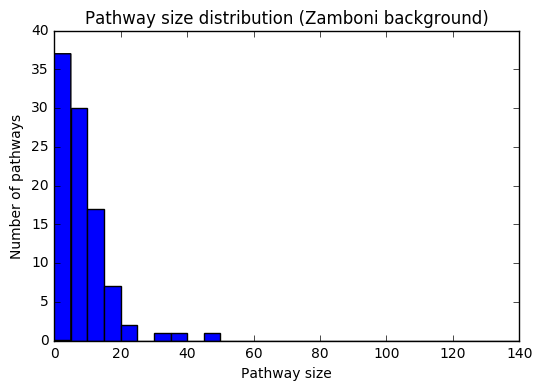

In [12]:
print(min(zamboni_size_dist), max(zamboni_size_dist))
plt.hist(zamboni_size_dist, bins=range(0, 145, 5))
plt.ylim(0, 40)
plt.xlabel('Pathway size')
plt.ylabel('Number of pathways')
plt.title('Pathway size distribution (Zamboni background)')
plt.show()

1
138


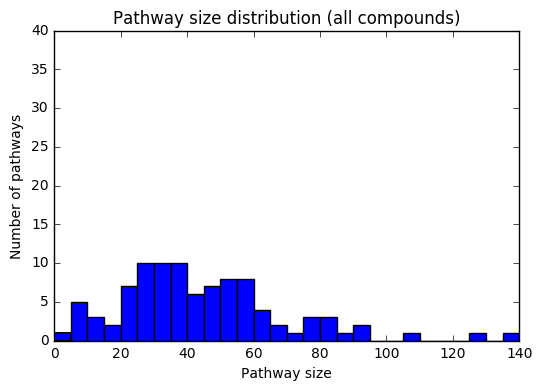

In [13]:
print(min(size_dist))
print(max(size_dist))
plt.hist(size_dist, bins=range(0, 145, 5))
plt.ylim(0, 40)
plt.xlabel('Pathway size')
plt.ylabel('Number of pathways')
plt.title('Pathway size distribution (all compounds)')
plt.show()

## Analysis 3: Random metabolite misidentification
-Data noise

-misindentification

*Repeat it for many times

*Summarize the results (Number of significant pathways; Rank KOs based on length of list)

### Zamboni background length: 413
5% = 20
10% = 41
20% = 82
50% = 206

In [10]:
random_knockouts = np.random.randint(3717, size=50)

In [12]:
random_knockouts = np.array([2673,  470, 3457,  859, 2461, 2776,  514, 1537, 3114, 2120, 2880,
       1312,  484, 3494,  110,   29, 1514,  791, 1925, 1131, 2776, 1274,
       1342,  875, 2235, 2938, 1460, 2957,  718, 1214, 3058,  509, 3215,
       2066, 2598, 3622, 3627,  436, 2223, 2691, 2442, 3439, 2490, 1223,
         90, 1902, 1893,  929, 3349,  746])

In [25]:
print(zero, one, two, more)
print(20)

{'fn': 0, 'fp': 13} {'fn': 296, 'fp': 49} {'fn': 527, 'fp': 47} {'fn': 999, 'fp': 42}
20


In [27]:
print(zero, one, two, more)
print(10)

{'fn': 0, 'fp': 9} {'fn': 209, 'fp': 31} {'fn': 339, 'fp': 33} {'fn': 664, 'fp': 29}
10


In [26]:
import os

zero = {}
one = {}
two = {}
more = {}
for file in os.listdir('./mis_ident50/3more'):
    path = './mis_ident10/3more/' + file
    fh = open(path, 'r')
    lines = fh.readlines()
    for line in lines:
        fields = line.rstrip().split('\t')
        total_hits = int(fields[0])
        false_pos = int(fields[1])
        false_neg = int(fields[2])
        if total_hits == 0:
            zero['fp'] = zero.get('fp', 0) + false_pos
            zero['fn'] = zero.get('fn', 0) + false_neg
        elif total_hits == 1:
            one['fp'] = one.get('fp', 0) + false_pos
            one['fn'] = one.get('fn', 0) + false_neg
        elif total_hits == 2:
            two['fp'] = two.get('fp', 0) + false_pos
            two['fn'] = two.get('fn', 0) + false_neg
        elif total_hits >= 3:
            more['fp'] = more.get('fp', 0) + false_pos
            more['fn'] = more.get('fn', 0) + false_neg
    fh.close()

In [13]:
# Random metabolite mutation
mutation_rate = 0.5
filename = './mis_ident/new/mrate50.tsv'
fh = open(filename, 'w')
for ko_number in random_knockouts:
    fp = 0
    fn = 0
    ora_results = []
    for i in range(0, 51):
        ora_results.append([])
    (pvals, pathwayids, junk) = oras_ko(ko_number, ecoli_pathways, zamboni_bg, pathway_2_compounds, 
                                  pos_annot, pos_mod, neg_annot, neg_mod, 2, 
                                  True, False, 0, [])
    for ind in range(0, len(pvals)):
        if pvals[ind] < 0.05:
            ora_results[0].append(pathwayids[ind])

    for k in range(0, 50): # Number of mutations per ko
        #print(k)
        (pvals_mut, pathwayids_mut, junk) = oras_ko(ko_number, ecoli_pathways, zamboni_bg, pathway_2_compounds, 
                                              pos_annot, pos_mod, neg_annot, neg_mod, 2, 
                                              True, False, int(mutation_rate * 413), test_compounds)
        for ind in range(0, len(pvals_mut)):
            if pvals_mut[ind] < 0.05:
                ora_results[k+1].append(pathwayids_mut[ind])
    # write ora_result to a file
    for i in range(1, len(ora_results)):
        result = ora_results[i]
        fp += len(set(result) - set(ora_results[0]))
        fn += len(set(ora_results[0]) - set(result))
    fh.write('\t'.join([str(len(ora_results[0])), str(fp), str(fn), str(ko_number)]))
    fh.write('\n')
fh.close()

In [28]:
fh = open('./mis_ident/new/mrate50.tsv', 'r')
lines = fh.readlines()
fp_all = []
fn_all = []
for line in lines:
    fields = line.rstrip().split('\t')
    tp = int(fields[0])
    fp = int(fields[1])
    fn = int(fields[2])
    fp_all.append(fp)
    if tp != 0:
        fn_all.append(fn)
fh.close()
print(np.mean(fp_all)/50, np.mean(fn_all)/50, sum(fn_all)/2500)

0.0416 1.16 0.1624


In [80]:
count = -1
for k in ora_results:
    if k == ora_results[0]:
        count += 1
print(count)

0


## Analysis 4: Getting 'correct' answer
Only include metabolic enzyme (EC number)

Annotation (missing/incorrect)

Dont use a cutoff

Biological?Chemical?Statistical?

In [14]:
eco_enzymes

[4,
 5,
 11,
 12,
 13,
 14,
 16,
 17,
 18,
 25,
 30,
 36,
 38,
 40,
 43,
 45,
 46,
 49,
 50,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 65,
 68,
 69,
 70,
 72,
 73,
 75,
 78,
 80,
 81,
 82,
 85,
 86,
 87,
 95,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 108,
 109,
 113,
 114,
 115,
 116,
 117,
 118,
 120,
 121,
 122,
 123,
 134,
 136,
 137,
 143,
 144,
 145,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 159,
 160,
 161,
 162,
 163,
 165,
 167,
 169,
 174,
 176,
 177,
 181,
 182,
 183,
 184,
 188,
 189,
 190,
 191,
 192,
 193,
 194,
 196,
 204,
 205,
 207,
 208,
 211,
 213,
 218,
 226,
 235,
 236,
 238,
 242,
 243,
 245,
 246,
 248,
 249,
 250,
 252,
 254,
 257,
 258,
 259,
 261,
 262,
 263,
 265,
 269,
 271,
 273,
 274,
 275,
 277,
 278,
 280,
 281,
 282,
 283,
 284,
 285,
 286,
 288,
 289,
 291,
 292,
 293,
 294,
 295,
 297,
 306,
 331,
 332,
 337,
 341,
 343,
 344,
 346,
 347,
 349,
 350,
 352,
 353,
 354,
 355,
 356,
 357,
 358,
 359,
 360,
 362,
 368,
 370,
 372,
 3

In [12]:
eco_enzymes = []
for i in range(0, len(all_knockouts)):
    print(i)
    try:
        if 'Enzymes' in k.parse(k.get(k.find('eco', all_knockouts[i])[:9])).get('BRITE', []):
            eco_enzymes.append(i)
    except AttributeError:
        pass

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [21]:
outfile = './locality/allKO.tsv'
fh = open(outfile, 'w')
for ko_number in eco_enzymes:
    print(ko_number)
    ko_gene = all_knockouts[ko_number]
    gene_id = k.find("eco", ko_gene)[:9]
    try:
        gene_pathways = k.parse(k.get(gene_id))['PATHWAY'].keys()
    except KeyError:
        gene_pathways = []
    except TypeError:
        gene_pathways = []
    if len(gene_pathways) > 0:
        fh.write(str(ko_number) + '\t' + ko_gene + '\t')
        fh.write(' '.join(list(gene_pathways)))
        fh.write('\n')
fh.close()

4
5
11
12
13
14
16
17
18
25
30
36
38
40
43
45
46
49
50
53
54
55
56
57
58
59
60
65
68
69
70
72
73
75
78
80
81
82
85
86
87
95
98
99
100
101
102
103
104
105
106
108
109
113
114
115
116
117
118
120
121
122
123
134
136
137
143
144
145
147
148
149
150
151
152
153
154
155
159
160
161
162
163
165
167
169
174
176
177
181
182
183
184
188
189
190
191
192
193
194
196
204
205
207
208
211
213
218
226
235
236
238
242
243
245
246
248
249
250
252
254
257
258
259
261
262
263
265
269
271
273
274
275
277
278
280
281
282
283
284
285
286
288
289
291
292
293
294
295
297
306
331
332
337
341
343
344
346
347
349
350
352
353
354
355
356
357
358
359
360
362
368
370
372
375
377
378
387
393
397
398
399
400
401
402
404
405
406
407
411
413
414
418
421
423
428
429
431
432
436
439
447
449
454
455
458
466
471
480
481
482
483
484
490
491
495
497
498
507
511
512
514
515
517
518
519
520
521
524
529
530
533
548
557
561
577
579
580
607
622
623
624
625
626
627
632
634
636
638
639
640
641
643
644
646
647
649
650
651
654
655
65

### Methods
Gather the following statistics:

How many got ranked significant?

How many significant in ORA but not related?

What is the average rank of related pathways?

In [37]:
from operator import itemgetter
# Get KO number
# Load rankings for that KO
# Get significant/not related/average rank
kegg_results = './locality/allKO.tsv'
fh = open(kegg_results, 'r')
result_lines = fh.readlines()
fh.close()
out_fh = open('./locality/outresult_sig.tsv', 'w')
out_fh.write('KO_number\tGene\tSigpathways\tNot_KEGG\tSigKEGG\tRank\tPath_count\n')
for line in result_lines:
    fields = line.rstrip().split('\t')
    ko_number = fields[0]
    ko_name = fields[1]
    ko_kegg_pathways = fields[2].split()
    
    ko_ora_results = './allresult/KO' + ko_number + '.tsv'
    fh = open(ko_ora_results, 'r')
    ora_lines = fh.readlines()
    fh.close()
    ora_pvals = []
    ora_pathways = []
    ora_sigpathways = []
    for oraline in ora_lines:
        ora_pathway_result = oraline.rstrip().split('\t')
        ora_pvals.append(ora_pathway_result[1])
        ora_pathways.append(ora_pathway_result[0])
        if float(ora_pathway_result[1]) < 0.05:
            ora_sigpathways.append(ora_pathway_result[0])
    pathway_rank = dict(zip(ora_pathways, list(dup_argsort(ora_pvals))))
    # Sigpathway
    not_related_pathways = len(set(ora_sigpathways) - set(ko_kegg_pathways))
    missing_pathways = len(set(ko_kegg_pathways) - set(ora_sigpathways))
    # average rank
    ranksum = 0
    path_count = 0
    for path in ko_kegg_pathways:
        try:
            rank = pathway_rank[path]
            ranksum += rank
            path_count += 1
        except KeyError:
            pass
    if path_count != 0:
        rankavg = ranksum/path_count
    else:
        rankavg = 'N'
    output_str = '\t'.join([ko_number, ko_name, 
                  str(len(ora_sigpathways)), str(not_related_pathways), str(len(ora_sigpathways) - not_related_pathways), str(rankavg), str(path_count)])
    if len(ora_sigpathways) > 0:
        out_fh.write(output_str+'\n')
out_fh.close()

In [25]:
a2 = np.array([4,2,1,1,2])
def dup_argsort(in_val):
    u, v = np.unique(in_val, return_inverse=True)
    out_ind = (np.cumsum(np.concatenate(([0], np.bincount(v)))))[v]
    return out_ind
dup_argsort(a2)

array([4, 2, 0, 0, 2])

In [51]:
fh = open('./2281.tsv', 'w')
fh.write('Gene\tKegg\tKegg_path\tSig_path(0.1)\tMinPval\n')
for ko_number in range(2281, 2282):
    print(ko_number)
    ko_gene = all_knockouts[ko_number]
    gene_id = k.find("eco", ko_gene)[:9]
    try:
        gene_pathways = k.parse(k.get(gene_id))['PATHWAY'].keys()
    except KeyError:
        gene_pathways = []
    except TypeError:
        gene_pathways = []
    if len(gene_pathways) >= 0:
        #print(ko_gene, gene_id)
        #print(list(gene_pathways))
        significant_pathways = []
        (pvals, pathwayids, junk) = oras_ko(ko_number, ecoli_pathways, zamboni_bg, pathway_2_compounds, 
                                      pos_annot, pos_mod, neg_annot, neg_mod, 2, 
                                      False, False, 0, [])
        for ind in range(0, len(pvals)):
            if pvals[ind] < 0.1:
                significant_pathways.append(pathwayids[ind])
        fh.write('{}\t{}\t{}\t{}\t{}\n'.format(ko_gene, gene_id, list(gene_pathways), significant_pathways, min(pvals)))
fh.close()

2281


## Analysis 5: Rank analysis
### ORA vs MetaboAnalyst

In [43]:
for metabolite in build_metabo_input(0, pos_annot, pos_mod, neg_annot, neg_mod, 2):
    print(metabolite)

C03090
C00644
C00048
C00037
C01103
C06840
C03406
C00082
C00296
C00246
C00417
C04438
C05822
C05818
C16186
C06156
C00460
C06193
C00855
C00314
C01233
C03274
C04332
C06735
C00719


In [46]:
(pval, pathwayid, pathwaysize) = oras_ko(0, ecoli_pathways, zamboni_bg, pathway_2_compounds, 
                           pos_annot, pos_mod, neg_annot, neg_mod, 2, False, False, 0)

In [77]:
def kegg_2_name(kegg_id, kegg_instance):
    return kegg_instance.parse(kegg_instance.get(kegg_id))['NAME'][0].split(' - ')[0]

In [110]:
kegg_2_name('path:eco00330', k)

'Arginine and proline metabolism'

In [112]:
len(k.parse(k.get('path:eco00401'))['COMPOUND'])

32

In [109]:
pval = np.array(pval)
pvalind = np.argsort(pval)
for i in pvalind:
    size = pathwaysize[i]
    ptw = pathwayid[i]
    ptwname = kegg_2_name(ptw, k)
    print(ptw, size, ptwname, pval[i])

path:eco00660 6 C5-Branched dibasic acid metabolism 0.0454630582039
path:eco00460 7 Cyanoamino acid metabolism 0.0613037310008
path:eco00630 18 Glyoxylate and dicarboxylate metabolism 0.0873661914665
path:eco00565 2 Ether lipid metabolism 0.117539199323
path:eco00401 2 Novobiocin biosynthesis 0.117539199323
path:eco00680 21 Methane metabolism 0.126201110982
path:eco00260 22 Glycine, serine and threonine metabolism 0.140382514438
path:eco00730 12 Thiamine metabolism 0.16002185
path:eco02026 3 Biofilm formation 0.171216863598
path:eco00250 13 Alanine, aspartate and glutamate metabolism 0.182299400879
path:eco00400 13 Phenylalanine, tyrosine and tryptophan biosynthesis 0.182299400879
path:eco00970 14 Aminoacyl-tRNA biosynthesis 0.205045708558
path:eco00440 4 Phosphonate and phosphinate metabolism 0.221752420696
path:eco00564 15 Glycerophospholipid metabolism 0.228129680723
path:eco02060 17 Phosphotransferase system (PTS) 0.274850252311
path:eco00130 17 Ubiquinone and other terpenoid-quino

In [74]:
for ko_number in range(0, 3717):
    result_file = './Backgrounds/KO' + str(ko_number) + '.tsv'
    in_fh = open(result_file, 'r')
    lines = in_fh.readlines()
    out_fh = open(('./allresult/KO') + str(ko_number) + '.tsv', 'w')
    for line in lines:
        fields = line.rstrip().split('\t')
        pathway_id = fields[0]
        zamboni_pval = float(fields[3])
        pvalue = 10**(np.negative(zamboni_pval))
        out_fh.write('{}\t{}\n'.format(pathway_id, pvalue))
    out_fh.close()
    in_fh.close()

In [10]:
number_of_hits = {}
for ko_number in range(0, 3717):
    result_file = './allresult/KO' + str(ko_number) + '.tsv'
    fh = open(result_file, 'r')
    lines = fh.readlines()
    sig_pathway = 0
    for line in lines:
        fields = line.rstrip().split('\t')
        pvalue = float(fields[1])
        if pvalue < 0.05:
            sig_pathway += 1
    number_of_hits[ko_number] = sig_pathway

In [82]:
oras_ko(333, ecoli_pathways, zamboni_bg, pathway_2_compounds, pos_annot, pos_mod, neg_annot, neg_mod, 2, True, False, 0, [])

([0.373488152048454,
  0.44946980592280733,
  0.44946980592280733,
  0.44946980592280733,
  0.44946980592280733,
  0.5932473934585375,
  0.8803602402482741,
  0.3708286364863693,
  0.5964699048408784,
  0.45965731191454845,
  0.5932473934585375,
  0.28985600967619185,
  0.46631207243023726,
  0.4095537890998013,
  0.489068883808352,
  0.44946980592280733,
  0.030015365666511404,
  0.44946980592280733,
  0.030015365666511404,
  0.373488152048454,
  0.489068883808352,
  0.4095537890998013,
  0.4095537890998013,
  0.4095537890998013,
  0.5932473934585375,
  0.4095537890998013,
  0.44946980592280733,
  0.030015365666511404,
  0.46631207243023726,
  0.30508474576270195,
  0.45965731191454845,
  0.489068883808352,
  0.5478741334136651,
  0.5478741334136651,
  0.4095537890998013],
 ['path:eco00010',
  'path:eco00030',
  'path:eco00040',
  'path:eco00051',
  'path:eco00052',
  'path:eco00130',
  'path:eco00230',
  'path:eco00260',
  'path:eco00270',
  'path:eco00350',
  'path:eco00360',
  'pat

In [11]:
no_hits = []
for ko in number_of_hits:
    if number_of_hits[ko] == 0:
        no_hits.append(ko)

In [21]:
no_hits

[0,
 1,
 2,
 3,
 4,
 5,
 7,
 8,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 37,
 38,
 39,
 40,
 41,
 42,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 75,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 91,
 92,
 93,
 94,
 95,
 97,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 185,
 186,
 187,
 188,
 189,
 190,
 191,
 192,
 193,
 194,
 195,
 

In [89]:
total = 0
for ko in number_of_hits:
    total += number_of_hits[ko]
total

472